# Assignment - 3 (Natural Language Processing)

### Team Members :-
1. Donal Loitam (AI21BTECH11009)
2. Iragavarapu Sai Pradeep (AI21BTECH11013)
3. Suraj Kumar (AI21BTECH11029)

### **Project Setup & Overview**
**Title:** Pedagogical Ability Assessment of AI Tutors (Problem 2)

**Dataset:** MathDial/Bridge dataset containing tutor-student dialogues (JSON format). Assumed structure: List of conversations, each containing conversation_history and a list of tutor_responses, where each response has response text and annotation labels for the four tasks.

##### Tasks:
- Mistake Identification (Yes/To some extent/No)
- Mistake Location (Yes/To some extent/No)
- Pedagogical Guidance (Yes/To some extent/No)
- Actionability (Yes/To some extent/No)

**Evaluation Metrics**: Exact Accuracy, Exact Macro F1, Lenient Accuracy, Lenient Macro F1 for each task.



In [30]:
# Uncomment the below line to install these if not already

# !pip install transformers datasets scikit-learn pandas torch

In [31]:
# --- Standard Libraries ---
import json
import os
import random
import string
import re
import traceback

# --- Data Handling ---
import pandas as pd
import numpy as np

# --- Machine Learning & NLP ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# PyTorch for modeling
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Hugging Face Transformers for models and tokenizers
import transformers
from transformers import AutoTokenizer, AutoModel # Base classes, specific models loaded later

# --- Visualization --
import matplotlib.pyplot as plt
import seaborn as sns

# --- NLTK (Optional, for Stopwords) ---
import nltk
try:
    from nltk.corpus import stopwords
    stopwords.words('english') # Check if already downloaded
except LookupError:
    print("NLTK stopwords not found. Downloading...")
    nltk.download('stopwords')
    from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))



# ---------------- Configuration & Constants -------------------------------
# Seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# --- Paths ---
DATA_PATH = 'assignment_3_ai_tutors_dataset.json'
OUTPUT_DIR = './results' # Directory to save models, logs, etc.
os.makedirs(OUTPUT_DIR, exist_ok=True) # Create output dir if it doesn't exist

# --- Device Setup ---
DEVICE = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# --- Experiment Parameters ---
BASE_MODELS_TO_TRY = ['distilbert-base-uncased', 'bert-base-uncased', 'roberta-base']
PREPROCESSING_OPTIONS = {
    'remove_punct': [False], # Try both keeping and removing punctuation
    'remove_stopwords': [False], # Start with keeping stopwords (often important for context)
    'include_history': [False] # Try with and without conversation history
}
# TASK_STRATEGIES = ['single_task', 'multi_task']
TASK_STRATEGIES = ['single_task']
# LOSS_FUNCTIONS_TO_TRY = ['CrossEntropyLoss', 'WeightedCrossEntropyLoss', 'FocalLoss']
LOSS_FUNCTIONS_TO_TRY = ['FocalLoss']

# --- Model Hyperparameters (can be tuned) ---
MAX_LENGTH = 384  # Max sequence length for tokenizer (adjust based on EDA)
BATCH_SIZE = 32   # Adjust based on GPU memory
EPOCHS = 5        # Number of training epochs
LEARNING_RATE = 2e-5 # Common learning rate for fine-tuning transformers

# --- Label Mapping ---
LABEL_MAP = {"Yes": 0, "To some extent": 1, "No": 2}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
NUM_CLASSES = len(LABEL_MAP)

# Task names mapping to keys expected in the dataset's annotation dictionary
TASK_KEYS = {
    "Mistake_Identification": "Mistake_Identification", # Column name : JSON Key
    "Mistake_Location": "Mistake_Location",
    "Providing_Guidance": "Providing_Guidance", # Note the different key name
    "Actionability": "Actionability"
}

TASK_LIST = list(TASK_KEYS.keys())

print("Setup Complete.")


Using device: cuda:2
Setup Complete.


### **Data Loading**
The following cell defines a function load_data to read the dataset from the specified JSON file (DATA_PATH).

It parses the nested structure, extracts the relevant fields (conversation history, tutor response, and the four pedagogical annotations), maps the text labels ("Yes", "To some extent", "No") to integers (0, 1, 2 respectively), and organizes everything into a Pandas DataFrame.

Each row in the resulting DataFrame will represent a single tutor response instance ready for analysis.

In [32]:
def load_data(file_path):
    """
    Loads and parses the dataset from a JSON file based on the user-provided structure.

    Args:
        file_path (str): The path to the JSON dataset file.

    Returns:
        pandas.DataFrame: A DF where each row corresponds to a single
                          tutor response instance, including context and labels.
                          Returns None if the file cannot be loaded or parsed.

    Expected JSON Structure :
    [
        {
            "conversation_id": "...",
            "conversation_history": "...",
            "tutor_responses": {  <--- This is a DICTIONARY
                "Tutor Name/ID 1": {
                    "response": "...",
                    "annotation": {
                        "Mistake_Identification": "Yes" | "To some extent" | "No",
                        "Mistake_Location": "Yes" | "To some extent" | "No",
                        "Providing_Guidance": "Yes" | "To some extent" | "No",
                        "Actionability": "Yes" | "To some extent" | "No"
                    }
                },
                "Tutor Name/ID 2": { ... },
                ...
            }
        },
        ... // More conversations
    ]
    """
    data_rows = []
    # Check if file exists before trying to open
    if not os.path.exists(file_path):
        print(f"Error: Dataset file not found at {file_path}")
        return None

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            dataset = json.load(f)

        # Ensure dataset is a list
        if not isinstance(dataset, list):
            print(f"Error: Expected a list of conversations in JSON, but got type {type(dataset)}. Check JSON structure.")
            return None

        for i, conversation in enumerate(dataset):

            conv_id = conversation.get("conversation_id", f"N/A_{i}")
            history = conversation.get("conversation_history", "")

            # Get the tutor_responses dictionary
            tutor_responses_dict = conversation.get("tutor_responses", {})

            # Iterate through the dictionary items (tutor_name, tutor_data)
            for tutor_name, tutor_data in tutor_responses_dict.items():

                response_text = tutor_data.get("response", "")
                annotations = tutor_data.get("annotation", {})

                labels = {}
                valid_entry = True
                # Iterate through the desired column names and their corresponding JSON keys
                for df_col_name, json_key in TASK_KEYS.items():
                    label_text = annotations.get(json_key)
                    if label_text in LABEL_MAP:
                        labels[df_col_name] = LABEL_MAP[label_text]
                    else:
                        print(f"Warning: Invalid or missing label '{label_text}' for annotation key '{json_key}' in conv {conv_id}, tutor {tutor_name}. Skipping response.")
                        valid_entry = False
                        break # Skip this response if any label is invalid/missing

                if valid_entry:
                    data_rows.append({
                        "conversation_id": conv_id,
                        "conversation_history": history,
                        "tutor": tutor_name,
                        "response": response_text,
                        **labels # Unpack the label dictionary (e.g., "Mistake_Identification": 0, ...)
                    })

        if not data_rows:
             print(f"Warning: No valid data rows extracted from {file_path} after processing. Check file structure, content, and warnings.")
             df_columns = ["conversation_id", "conversation_history", "tutor", "response"] + TASK_LIST
             return pd.DataFrame(columns=df_columns)


        df = pd.DataFrame(data_rows)
        ordered_columns = ["conversation_id", "conversation_history", "tutor", "response"] + TASK_LIST
        df = df[ordered_columns]
        return df

    except json.JSONDecodeError as e:
        print(f"Error: Could not decode JSON from {file_path}. Check file format. Details: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred during data loading: {e}")
        traceback.print_exc() # Print detailed traceback for debugging
        return None


# Check if DATA_PATH is defined and points to a file
if 'DATA_PATH' in locals() and DATA_PATH and os.path.exists(DATA_PATH):
    print(f"Attempting to load data from: {DATA_PATH}")
    df_raw = load_data(DATA_PATH)
elif 'DATA_PATH' in locals():
     print(f"Error: DATA_PATH ('{DATA_PATH}') is defined but does not exist. Please correct the path.")
     df_raw = None
else:
     print("Error: DATA_PATH is not defined. Please define it in the setup cell (Cell 2).")
     df_raw = None


# --- Display basic info ---
if df_raw is not None and not df_raw.empty:
    print(f"\nData loaded successfully using updated function. Shape: {df_raw.shape}")
    print("\nDataFrame Info:")
    df_raw.info()
    print("\nMissing values per column:")
    print(df_raw.isnull().sum())
    print("\nDataFrame Columns:", df_raw.columns.tolist())
elif df_raw is not None and df_raw.empty:
    print("\nData loading function ran, but returned an empty DataFrame. Check warnings and JSON content.")
else:
    print("\nData loading failed. Please check the DATA_PATH, file integrity, and error messages above.")



Attempting to load data from: assignment_3_ai_tutors_dataset.json

Data loaded successfully using updated function. Shape: (2476, 8)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2476 entries, 0 to 2475
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   conversation_id         2476 non-null   object
 1   conversation_history    2476 non-null   object
 2   tutor                   2476 non-null   object
 3   response                2476 non-null   object
 4   Mistake_Identification  2476 non-null   int64 
 5   Mistake_Location        2476 non-null   int64 
 6   Providing_Guidance      2476 non-null   int64 
 7   Actionability           2476 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 154.9+ KB

Missing values per column:
conversation_id           0
conversation_history      0
tutor                     0
response                  0
Mistake_Identification    0
Mist

In [33]:
print("First 10 rows of the df \n")
df_raw.head(10)

First 10 rows of the df 



,conversation_id,conversation_history,tutor,response,Mistake_Identification,Mistake_Location,Providing_Guidance,Actionability
0,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,"Tutor: Hi, could you please provide a step-by-...",Sonnet,"Great, you've correctly identified the cost of...",0,0,0,0
1,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,"Tutor: Hi, could you please provide a step-by-...",Llama318B,Now that we know the cost of 1 pound of meat i...,0,1,1,1
2,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,"Tutor: Hi, could you please provide a step-by-...",Llama31405B,"You're close, but I notice that you calculated...",0,0,0,0
3,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,"Tutor: Hi, could you please provide a step-by-...",GPT4,"That's correct. So, if 1 pound of meat costs $...",0,0,0,0
4,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,"Tutor: Hi, could you please provide a step-by-...",Mistral,It seems like you've calculated the cost as if...,0,0,0,0
5,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,"Tutor: Hi, could you please provide a step-by-...",Expert,"And if there are 5 sandwiches, what is the mea...",0,0,0,0
6,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,"Tutor: Hi, could you please provide a step-by-...",Gemini,You're absolutely right about the cost of meat...,0,1,1,1
7,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,"Tutor: Hi, could you please provide a step-by-...",Phi3,"To find the area of a rectangle, multiply its ...",2,2,1,2
8,4642-e2ccfa55-280b-421c-9245-25ff56e3f33e,"Tutor: Hi, could you please provide a step-by-...",GPT4,"You're doing great! But remember, the 20% incr...",0,0,0,0
9,4642-e2ccfa55-280b-421c-9245-25ff56e3f33e,"Tutor: Hi, could you please provide a step-by-...",Sonnet,"I see where you're going with this, but let's ...",1,2,2,1


### **Exploratory Data Analysis (EDA)**
This section performs Exploratory Data Analysis (EDA) to:

- **Analyze Label Distributions**: Check the frequency of each label ("Yes", "To some extent", "No") for all four tasks. This helps identify class imbalance, which might require special handling (e.g., weighted loss functions, specific sampling strategies).

- **Analyze Text Lengths**: Examine the distribution of lengths for response_text and history. This informs the choice of MAX_LENGTH for the tokenizer to balance capturing context and computational efficiency/memory usage

--- Starting Exploratory Data Analysis ---

--- Label Distributions ---


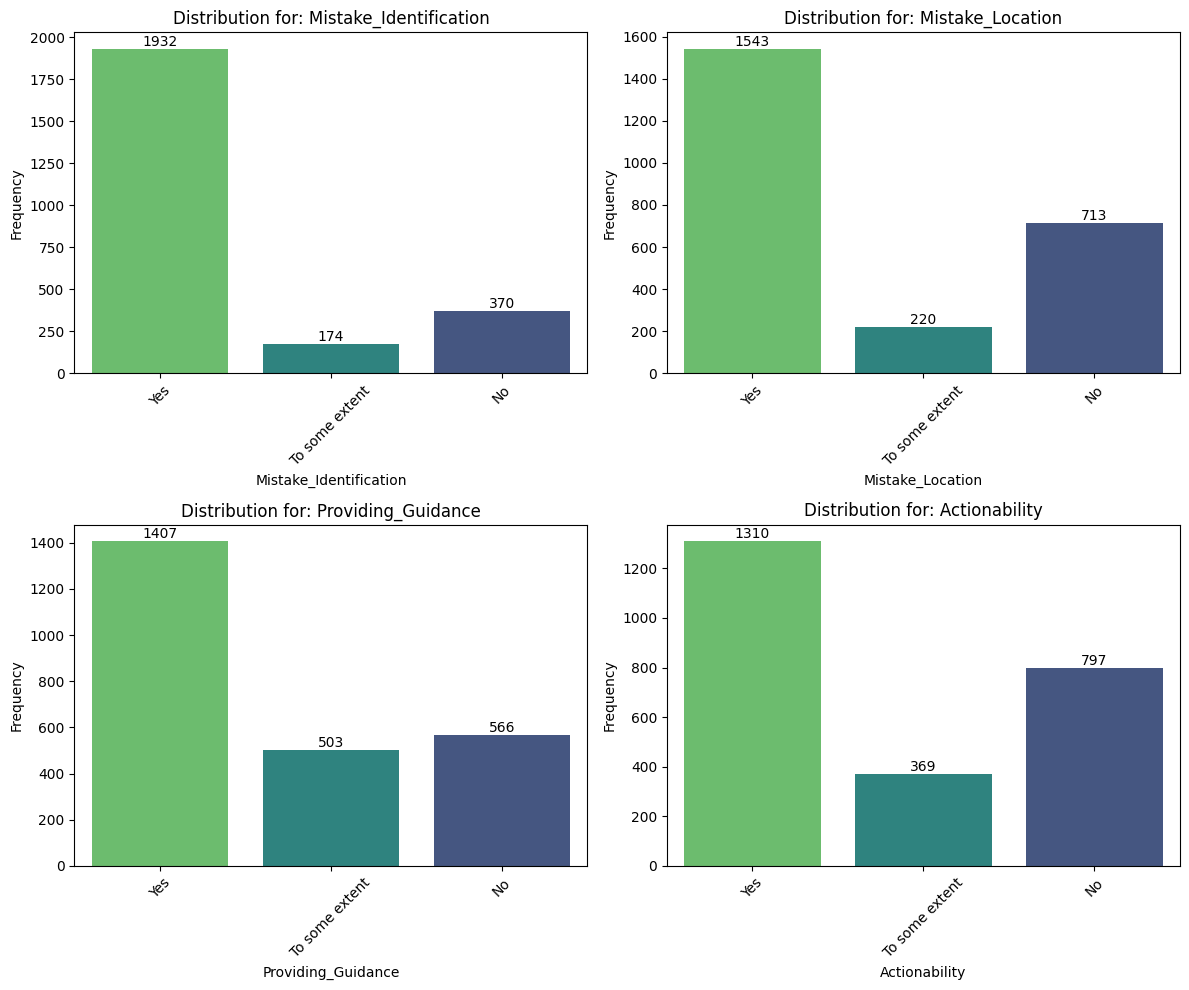


Value Counts for Mistake_Identification:
Mistake_Identification
Yes               1932
No                 370
To some extent     174
Name: count, dtype: int64

Value Counts for Mistake_Location:
Mistake_Location
Yes               1543
No                 713
To some extent     220
Name: count, dtype: int64

Value Counts for Providing_Guidance:
Providing_Guidance
Yes               1407
No                 566
To some extent     503
Name: count, dtype: int64

Value Counts for Actionability:
Actionability
Yes               1310
No                 797
To some extent     369
Name: count, dtype: int64

--- Text Length Analysis ---


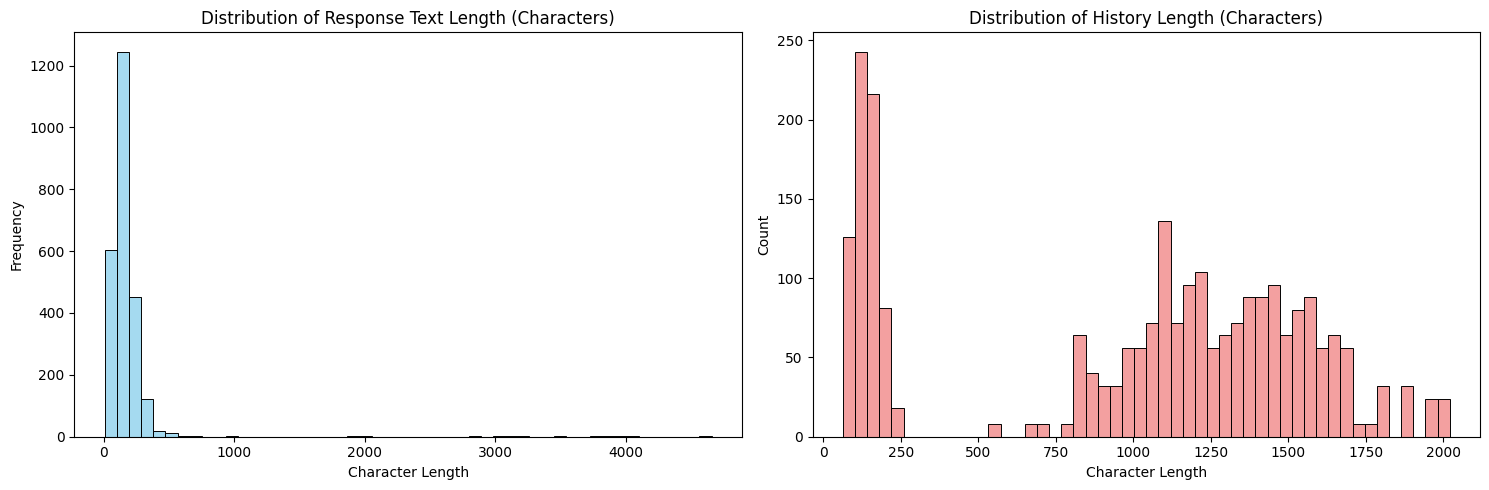

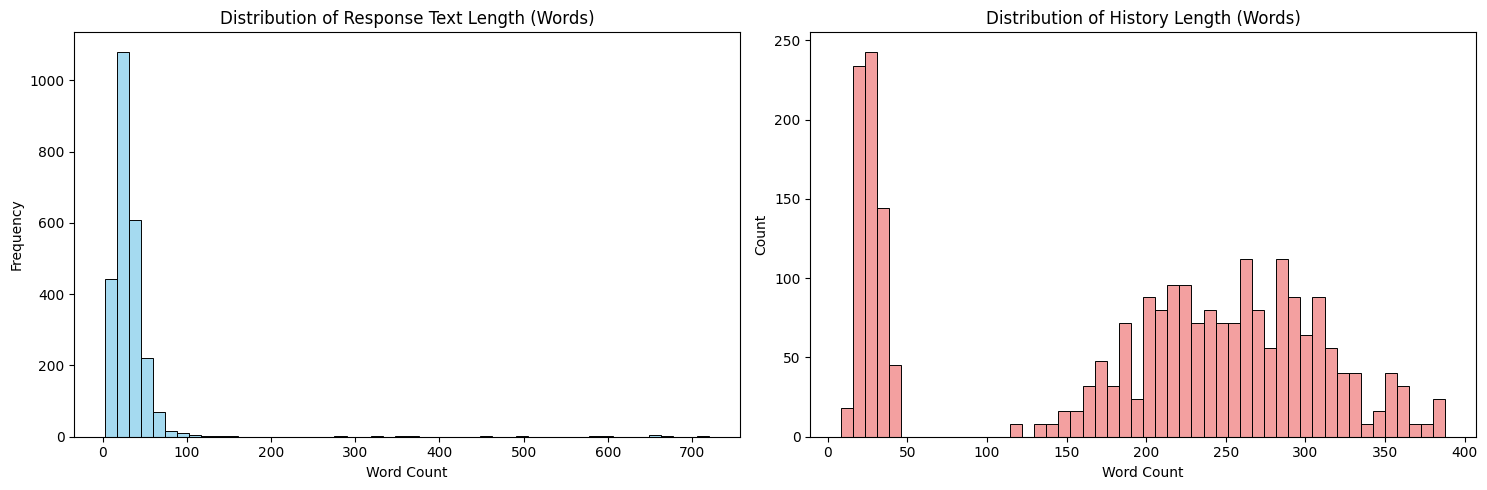


Descriptive Statistics for Text Lengths (Characters):
       response_len  history_len
count   2476.000000  2476.000000
mean     174.899031   988.957189
std      256.222749   579.441947
min        9.000000    63.000000
50%      146.000000  1144.000000
90%      262.000000  1629.500000
95%      310.000000  1723.000000
99%      532.000000  1973.000000
max     4656.000000  2021.000000

Descriptive Statistics for Text Lengths (Words):
       response_word_count  history_word_count
count          2476.000000         2476.000000
mean             32.339257          192.002019
std              44.575923          113.093320
min               2.000000            8.000000
50%              27.000000          221.000000
90%              49.000000          312.500000
95%              59.000000          348.000000
99%              99.000000          374.000000
max             721.000000          388.000000

Recommendation: Review the length distributions (especially word counts) to confirm if MAX_LEN

In [34]:
# Ensure df_raw was loaded successfully
if df_raw is not None:
    print("--- Starting Exploratory Data Analysis ---")

    # --- 1. Analyze Label Distributions ---
    print("\n--- Label Distributions ---")
    label_columns = [f'{task}' for task in TASK_LIST]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten() # Flatten to easily iterate

    for i, col in enumerate(label_columns):
        ax = axes[i]
        # Map numerical labels back to text for plotting
        label_counts = df_raw[col].map(INV_LABEL_MAP).value_counts().sort_index()
        sns.barplot(x=label_counts.index, y=label_counts.values, ax=ax, hue=label_counts.index, palette="viridis", order=["Yes", "To some extent", "No"])
        ax.set_title(f'Distribution for: {TASK_KEYS[TASK_LIST[i]]}')
        ax.set_ylabel('Frequency')
        ax.tick_params(axis='x', rotation=45)
        # Add counts on top of bars
        for container in ax.containers:
            ax.bar_label(container)

    plt.tight_layout()
    plt.show()

    # Print exact counts
    for col in label_columns:
         print(f"\nValue Counts for {col}:")
         print(df_raw[col].map(INV_LABEL_MAP).value_counts())


    # --- 2. Analyze Text Lengths ---
    print("\n--- Text Length Analysis ---")

    # Calculate lengths (number of characters)
    df_raw['response_len'] = df_raw['response'].str.len()
    df_raw['history_len'] = df_raw['conversation_history'].str.len()

    # Calculate lengths (number of words - approximate)
    df_raw['response_word_count'] = df_raw['response'].str.split().str.len()
    df_raw['history_word_count'] = df_raw['conversation_history'].str.split().str.len()


    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot character lengths
    sns.histplot(df_raw['response_len'], bins=50, ax=axes[0], color='skyblue')
    axes[0].set_title('Distribution of Response Text Length (Characters)')
    axes[0].set_xlabel('Character Length')
    axes[0].set_ylabel('Frequency')

    sns.histplot(df_raw['history_len'], bins=50, ax=axes[1], color='lightcoral')
    axes[1].set_title('Distribution of History Length (Characters)')
    axes[1].set_xlabel('Character Length')

    plt.tight_layout()
    plt.show()

    # Plot word counts
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(df_raw['response_word_count'], bins=50, ax=axes[0], color='skyblue')
    axes[0].set_title('Distribution of Response Text Length (Words)')
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')

    sns.histplot(df_raw['history_word_count'], bins=50, ax=axes[1], color='lightcoral')
    axes[1].set_title('Distribution of History Length (Words)')
    axes[1].set_xlabel('Word Count')

    plt.tight_layout()
    plt.show()


    # Print descriptive statistics for lengths
    print("\nDescriptive Statistics for Text Lengths (Characters):")
    print(df_raw[['response_len', 'history_len']].describe(percentiles=[0.90, 0.95, 0.99]))

    print("\nDescriptive Statistics for Text Lengths (Words):")
    print(df_raw[['response_word_count', 'history_word_count']].describe(percentiles=[0.90, 0.95, 0.99]))

    # Suggest MAX_LENGTH based on EDA (e.g., 95th percentile of combined length if including history)
    # This requires a specific base model's tokenizer to be accurate, but character/word counts give a good initial estimate.
    # Will refine MAX_LENGTH when tokenizing if needed.
    print(f"\nRecommendation: Review the length distributions (especially word counts) to confirm if MAX_LENGTH={MAX_LENGTH} is appropriate.")
    print("Consider the maximum input size supported by your chosen transformer models.")

    print("\n--- EDA Complete ---")

else:
    print("Skipping EDA because data loading failed.")

In [35]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Ensure df_raw and TASK_LIST are defined and df_raw is loaded

CLASS_WEIGHTS = {} # Dictionary to store weights for each task

if 'df_raw' in locals() and df_raw is not None and not df_raw.empty:
    print("--- Calculating Class Weights (based on the entire dataset) ---")
    # Ideally, calculate weights only on the training split, but using the whole
    # dataset is simpler for now and often a reasonable approximation.
    # To use only train split: perform split first, then calculate on train_df.

    for task_name in TASK_LIST:
        if task_name in df_raw.columns:
            labels = df_raw[task_name].dropna().unique()
            labels.sort() # Ensure consistent order [0, 1, 2]
            # Calculate weights using sklearn's utility
            # 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
            weights = compute_class_weight(class_weight='balanced',
                                           classes=labels,
                                           y=df_raw[task_name].dropna().values)
            # Store weights as a FloatTensor for PyTorch
            CLASS_WEIGHTS[task_name] = torch.tensor(weights, dtype=torch.float)
            print(f"  Task: {task_name}, Weights: {CLASS_WEIGHTS[task_name]}")
        else:
            print(f"Warning: Label column '{task_name}' not found. Cannot calculate weights.")

    # Example of how weights might look (will vary based on your data):
    # Task: Mistake_Identification, Weights: tensor([0.4281, 2.9787, 1.4894])
    # Task: Mistake_Location, Weights: tensor([0.5363, 2.3579, 0.8714])
    # ... etc ...
else:
    print("Skipping class weight calculation because df_raw is not available.")



--- Calculating Class Weights (based on the entire dataset) ---
  Task: Mistake_Identification, Weights: tensor([0.4272, 4.7433, 2.2306])
  Task: Mistake_Location, Weights: tensor([0.5349, 3.7515, 1.1576])
  Task: Providing_Guidance, Weights: tensor([0.5866, 1.6408, 1.4582])
  Task: Actionability, Weights: tensor([0.6300, 2.2367, 1.0355])


#### **EDA takeaways** :
Here are a few key takeaways relevant to the next steps:

1. **Class Imbalance**: As the value counts show, there's a noticeable imbalance in the labels for all four tasks, especially with "To some extent" and sometimes "No" being minority classes. This brings up the idea that using techniques like weighted loss functions* (e.g., Focal Loss, or passing class weights to CrossEntropyLoss)* or careful evaluation metrics (like *Macro F1*) will be important during training and evaluation. *Stratified splitting* in create_dataloaders is also a good step.

2. **Text Length & MAX_LENGTH**:
The response lengths are mostly moderate (95% percentile at 59 words), but with some very long outliers.
The history lengths are significantly longer (95% percentile at 348 words).
The current MAX_LENGTH=256 seems like a reasonable starting point, especially if we don't include the full history. If we do include history (include_history=True), we may experience significant truncation of the history part for many examples. This is a trade-off: including history might provide crucial context, but truncation might lose some of that context. We might experiment with different MAX_LENGTH values (e.g., 512, if the chosen models support it and memory allows) or different strategies for combining history and response later.

### **Preprocessing Functions**
This section defines functions for cleaning the text data and preparing it for the model.
- **clean_text (Optional)**: A function to optionally remove punctuation and/or stopwords. Removing these can sometimes simplify the input but may also remove important contextual clues, especially in conversational data. We will make this configurable during experimentation.
- **TutorResponseDataset**: A custom PyTorch Dataset class. This class handles fetching individual data points, applying the selected cleaning options, combining history and response if specified, and using the Hugging Face tokenizer to convert the text into numerical input IDs and attention masks suitable for transformer models. It reads the label columns directly as defined in your DataFrame (e.g., Mistake_Identification).
- **create_dataloaders**: A helper function that takes the raw DataFrame, splits it into training, validation, and test sets, initializes the tokenizer and TutorResponseDataset for each split using the specified configuration, and finally creates PyTorch DataLoader objects to efficiently feed data to the model in batches.

In [36]:
import string
import re

# from nltk.corpus import stopwords
# STOPWORDS = set(stopwords.words('english')) # Defined in setup cell if uncommented

def clean_text(text, remove_punct=False, remove_stopwords=False):
    """
    Applies basic text cleaning options.

    Args:
        text (str): The input text.
        remove_punct (bool): Whether to remove punctuation.
        remove_stopwords (bool): Whether to remove NLTK English stopwords.

    Returns:
        str: The cleaned text.
    """
    if not isinstance(text, str):
        return "" # Return empty string for non-string inputs

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    if remove_punct:
        translator = str.maketrans('', '', string.punctuation)
        text = text.translate(translator)

    # Remove stopwords (optional)
    if remove_stopwords:
        if STOPWORDS:
            text = ' '.join([word for word in text.split() if word not in STOPWORDS])
        else:
            print("NLTK stopwords not loaded. Skipping stopword removal.")

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# --- Example Usage  ---
example = " This is an example response... with punctuation! And stopwords. "
print("Original:", example)
print("Cleaned (Punct):", clean_text(example, remove_punct=True, remove_stopwords=False))
print("Cleaned (Punct+Stopwords):", clean_text(example, remove_punct=True, remove_stopwords=True))
print("Cleaned (None):", clean_text(example, remove_punct=False, remove_stopwords=False))

Original:  This is an example response... with punctuation! And stopwords. 
Cleaned (Punct): this is an example response with punctuation and stopwords
Cleaned (Punct+Stopwords): example response punctuation stopwords
Cleaned (None): this is an example response... with punctuation! and stopwords.


In [37]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import pandas as pd
import os


class TutorResponseDataset(Dataset):
    """
    PyTorch Dataset class for tutor response classification.
    Handles text cleaning, formatting, and tokenization based on the
    DataFrame structure produced by the user's load_data function.
    """
    def __init__(self, dataframe, tokenizer, max_len, include_history=True, remove_punct=False, remove_stopwords=False):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing the data ('conversation_history',
                                      'response', and label columns like 'Mistake_Identification').
            tokenizer (transformers.PreTrainedTokenizer): Tokenizer instance.
            max_len (int): Maximum sequence length for tokenization.
            include_history (bool): Whether to prepend conversation history to the response.
            remove_punct (bool): Whether to remove punctuation during cleaning.
            remove_stopwords (bool): Whether to remove stopwords during cleaning.
        """
        # --- Input Validation ---
        if not isinstance(dataframe, pd.DataFrame) or dataframe.empty:
            raise ValueError("Input 'dataframe' must be a non-empty Pandas DataFrame.")
        if not hasattr(tokenizer, 'encode_plus'):
             raise ValueError("Input 'tokenizer' must be a valid Hugging Face tokenizer instance.")
        if not isinstance(max_len, int) or max_len <= 0:
             raise ValueError("'max_len' must be a positive integer.")
        # -----------------------

        self.tokenizer = tokenizer
        self.data = dataframe.reset_index(drop=True) # Ensure index is sequential
        self.max_len = max_len
        self.include_history = include_history
        self.remove_punct = remove_punct
        self.remove_stopwords = remove_stopwords

        # Get label column names directly from the global TASK_LIST
        # (TASK_LIST should contain ['Mistake_Identification', 'Mistake_Location', ...])
        self.label_columns = TASK_LIST
        # Verify label columns exist in the dataframe
        for col in self.label_columns:
            if col not in self.data.columns:
                raise ValueError(f"Label column '{col}' defined in TASK_LIST not found in the provided DataFrame.")


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Use .iloc for integer-based indexing after reset_index
        try:
            item = self.data.iloc[index]
        except IndexError:
             # This should ideally not happen if __len__ is correct, but good practice
             raise IndexError(f"Index {index} out of bounds for dataset with length {len(self)}")

        # Use column names consistent with user's DataFrame ('response', 'conversation_history')
        response_text = str(item.response)
        history_text = str(item.conversation_history)

        # Clean text based on flags
        cleaned_response = clean_text(response_text, self.remove_punct, self.remove_stopwords)
        cleaned_history = clean_text(history_text, self.remove_punct, self.remove_stopwords)

        # Combine history and response if specified
        if self.include_history and cleaned_history:
            # Use tokenizer's special separator token if available (e.g., [SEP])
            sep_token = self.tokenizer.sep_token if self.tokenizer.sep_token else " "
            final_text = cleaned_history + sep_token + cleaned_response
        else:
            final_text = cleaned_response

        # Tokenize
        encoding = self.tokenizer.encode_plus(
            final_text,
            add_special_tokens=True, # Add [CLS] and [SEP] (or model-specific tokens)
            max_length=self.max_len,
            padding='max_length',    # Pad to max_len
            truncation=True,         # Truncate if longer than max_len
            return_attention_mask=True,
            return_tensors='pt',     # Return PyTorch tensors
        )

        # Get labels for all tasks using the column names from TASK_LIST
        try:
            labels = torch.tensor([item[col] for col in self.label_columns], dtype=torch.long)
        except KeyError as e:
             # This should be caught by the __init__ check, but as a safeguard
             print(f"Error accessing label column at index {index}. Missing column: {e}")
             # Handle error appropriately - maybe return None or raise? For now, re-raise.
             raise e
        except Exception as e:
             print(f"Error processing labels at index {index}: {e}")
             raise e


        return {
            # Use .squeeze() to remove the batch dimension added by return_tensors='pt'
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': labels # Shape: [num_tasks] (e.g., [4])
        }

def create_dataloaders(df, tokenizer_name, batch_size, max_len, preprocessing_flags, test_size=0.1, val_size=0.1, random_state=SEED):
    """
    Creates train, validation, and test dataloaders.

    Args:
        df (pd.DataFrame): The full dataset DataFrame.
        tokenizer_name (str): Name of the Hugging Face tokenizer to load.
        batch_size (int): Batch size for the dataloaders.
        max_len (int): Maximum sequence length for tokenization.
        preprocessing_flags (dict): Dictionary containing 'include_history',
                                    'remove_punct', 'remove_stopwords' booleans.
        test_size (float): Proportion of data for the test set.
        val_size (float): Proportion of data for the validation set (taken from the initial training split).
        random_state (int): Random seed for splitting.

    Returns:
        tuple: (train_loader, val_loader, test_loader, tokenizer)
               Returns None for loaders if splitting fails or df is invalid.
    """
    if df is None or df.empty:
        print("Error: Input DataFrame is empty or None. Cannot create dataloaders.")
        return None, None, None, None
    if not all(flag in preprocessing_flags for flag in ['include_history', 'remove_punct', 'remove_stopwords']):
         print("Error: preprocessing_flags dictionary is missing required keys.")
         return None, None, None, None

    try:
        # Split data into Train+Validation and Test
        # Ensure TASK_LIST is available for potential stratification
        if 'TASK_LIST' not in globals():
             print("Error: Global variable TASK_LIST not found. Needed for stratification.")
             # Fallback: don't stratify if TASK_LIST is missing
             stratify_col = None
        else:
             # Use the first task's label column for stratification
             # Assumes TASK_LIST is ['Mistake_Identification', ...]
             stratify_col_name = TASK_LIST[0]
             if stratify_col_name in df.columns:
                  stratify_col = df[stratify_col_name]
             else:
                  print(f"Warning: Stratification column '{stratify_col_name}' not found. Proceeding without stratification.")
                  stratify_col = None

        train_val_df, test_df = train_test_split(
            df,
            test_size=test_size,
            random_state=random_state,
            stratify=stratify_col
        )

        # Split (Train + Validation) into Train and Validation
        # Adjust validation size relative to the remaining train_val data
        val_size_adjusted = val_size / (1.0 - test_size) if (1.0 - test_size) > 0 else 0

        # Stratify the second split as well
        if stratify_col is not None and stratify_col_name in train_val_df.columns:
             stratify_col_train_val = train_val_df[stratify_col_name]
        else:
             stratify_col_train_val = None # Cannot stratify if column missing in split

        train_df, val_df = train_test_split(
            train_val_df,
            test_size=val_size_adjusted,
            random_state=random_state, # Use same random state for consistency
            stratify=stratify_col_train_val
        )

        print(f"Data split sizes:")
        print(f"  Train: {len(train_df)}")
        print(f"  Validation: {len(val_df)}")
        print(f"  Test: {len(test_df)}")

        # Load tokenizer
        print(f"Loading tokenizer: {tokenizer_name}")
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

        # Create Dataset instances
        print("Creating Train Dataset...")
        train_dataset = TutorResponseDataset(train_df, tokenizer, max_len, **preprocessing_flags)
        print("Creating Validation Dataset...")
        val_dataset = TutorResponseDataset(val_df, tokenizer, max_len, **preprocessing_flags)
        print("Creating Test Dataset...")
        test_dataset = TutorResponseDataset(test_df, tokenizer, max_len, **preprocessing_flags)

        # Determine num_workers based on CPU count, handle potential issues
        try:
            num_workers = max(1, os.cpu_count() // 2 - 1) # Leave some cores free
        except NotImplementedError:
            num_workers = 0           # Fallback if cpu_count() is not available

        print(f"Using {num_workers} workers for DataLoaders.")

        # Create DataLoader instances
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=torch.cuda.is_available()) # Pin memory if using GPU
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=torch.cuda.is_available())
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=torch.cuda.is_available())

        print("Dataloaders created successfully.")
        return train_loader, val_loader, test_loader, tokenizer

    except ValueError as ve:
         # Catch specific ValueErrors raised in Dataset init
         print(f"ValueError during dataloader creation: {ve}")
         return None, None, None, None
    except Exception as e:
        print(f"An unexpected error occurred during dataloader creation: {e}")
        traceback.print_exc()
        return None, None, None, None


# --- Example Usage (Optional - Run this when you want to test a specific config) ---
if 'df_raw' in locals() and df_raw is not None and not df_raw.empty:
    print("\n--- Testing Dataloader Creation ---")
    # Example configuration
    test_tokenizer_name = 'distilbert-base-uncased' # Use a smaller model for quick test
    test_flags = {'include_history': True, 'remove_punct': False, 'remove_stopwords': False}

    train_loader_ex, val_loader_ex, test_loader_ex, tokenizer_ex = create_dataloaders(
        df_raw,
        test_tokenizer_name,
        batch_size=4, # Small batch for testing
        max_len=128,  # Smaller max_len for testing
        preprocessing_flags=test_flags,
        random_state=SEED # Use the global SEED
    )

    if train_loader_ex and tokenizer_ex:
        print("\nDataloaders created successfully for testing.")
        # Fetch one batch to inspect
        try:
            print("Fetching one batch from train_loader...")
            batch = next(iter(train_loader_ex))
            print("\nSample batch inspection:")
            print("Input IDs shape:", batch['input_ids'].shape) # Should be [batch_size, max_len]
            print("Attention Mask shape:", batch['attention_mask'].shape) # Should be [batch_size, max_len]
            print("Labels shape:", batch['labels'].shape) # Should be [batch_size, num_tasks]
            print("Sample Input IDs (first 20):", batch['input_ids'][0][:20]) # Print first 20 tokens of first sample
            print("Sample Labels:", batch['labels'][0])
            # Decode sample input
            print("Decoded Sample:", tokenizer_ex.decode(batch['input_ids'][0], skip_special_tokens=False))
        except Exception as e:
            print(f"Error inspecting batch: {e}")
            traceback.print_exc()
    else:
        print("\nDataloader creation failed during test.")
else:
     print("\nSkipping Dataloader test because df_raw is not available or empty.")




--- Testing Dataloader Creation ---
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: distilbert-base-uncased
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.

Dataloaders created successfully for testing.
Fetching one batch from train_loader...

Sample batch inspection:
Input IDs shape: torch.Size([4, 128])
Attention Mask shape: torch.Size([4, 128])
Labels shape: torch.Size([4, 4])
Sample Input IDs (first 20): tensor([  101, 14924,  1024,  7632,  1010,  2071,  2017,  3531,  3073,  1037,
         3357,  1011,  2011,  1011,  3357,  5576,  2005,  1996,  3160,  2917])
Sample Labels: tensor([0, 0, 0, 2])
Decoded Sample: [CLS] tutor : hi, could you please provide a step - by - step solution for the question below? the question is : anna used four baking trays to bake cupcakes. each tray has 20 cupcakes and each cupcake was then sold for $ 2. if only 3 / 5 of t

### **Model Definition**
Now, we will define the model architectures we plan to experiment with. We'll use pre-trained transformer models from Hugging Face as the base and add classification heads suitable for our tasks.

We will implement 2 main strategies:

- **Single-Task**: Train four separate models, one for each pedagogical dimension (Mistake_Identification, Mistake_Location, Providing_Guidance, Actionability). Each model will be a standard sequence classification model fine-tuned for one specific task. This is simpler to set up and debug.

- **Multi-Task**: Train a single model with a shared transformer base (e.g., BERT, DistilBERT) and four separate classification heads, one for each task. Our idea/conjecture is that the shared base may learn representations beneficial for all four related tasks, potentially leading to better performance or efficiency.

The code below provide functions/classes to create both types of models based on a chosen base model name.

In [38]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoModelForSequenceClassification, PreTrainedModel, AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput # For custom model output

# Ensure global constants NUM_CLASSES and TASK_LIST are available from Cell #2
# NUM_CLASSES = 3 (Yes, To some extent, No)
# TASK_LIST = ['Mistake_Identification', 'Mistake_Location', 'Providing_Guidance', 'Actionability']
NUM_TASKS = len(TASK_LIST) # Should be 4

# # --- Option A: Single-Task Model ---

from transformers import AutoModel, AutoConfig
import torch
import torch.nn as nn

class UltimatePenultimateModel(nn.Module):
    def __init__(self, base_model_name, num_labels):
        super(UltimatePenultimateModel, self).__init__()
        self.config = AutoConfig.from_pretrained(base_model_name, output_hidden_states=True)
        self.my_model = AutoModel.from_pretrained(base_model_name, config=self.config)
        hidden_size = self.config.hidden_size

        # self.hidden_layer = nn.Linear(2 * hidden_size, hidden_size)
        # self.activation = nn.ReLU()  # You could also use nn.GELU()
        # self.dropout = nn.Dropout(p=0.1)
        # self.classifier = nn.Linear(hidden_size, num_labels)
        # self.hidden_layer = nn.Linear(2 * hidden_size, hidden_size)
        # self.norm = nn.LayerNorm(hidden_size)
        # self.activation = nn.GELU()
        # self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size, num_labels)


        # Since we're concatenating last + second last, total input size to classifier = 2 * hidden_size
        # self.classifier = nn.Linear(2 * hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None,return_dict=True):
      outputs = self.my_model(
          input_ids=input_ids,
          attention_mask=attention_mask,
      )

      hidden_states = outputs.hidden_states

    #   last_cls = hidden_states[-1][:, 0, :]        # [CLS] token from last layer
    #   second_last_cls = hidden_states[-2][:, 0, :] # [CLS] token from second last layer
      third_last_cls = hidden_states[-3][:, 0, :] # [CLS] token from third last layer
    #   concat_cls = torch.cat((last_cls, second_last_cls), dim=-1)
      concat_cls=third_last_cls
    #   concat_cls = torch.cat((third_last_cls, third_last_cls), dim=-1) # Concatenate the CLS tokens
      # logits = self.classifier(concat_cls)
      # x = self.hidden_layer(concat_cls)
      # x = self.activation(x)
      # x = self.dropout(x)
      # logits = self.classifier(x)


    #   x = self.hidden_layer(concat_cls)
    #   x = self.norm(x)
    #   x = self.activation(x)
    #   x = self.dropout(x)
      logits = self.classifier(concat_cls)
      # loss = None
      # if labels is not None:
      #     loss_fct = nn.CrossEntropyLoss()
      #     loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))


      # if return_dict:
      #   return {"logits": logits}
      # return logits

      # loss = None
      # if labels is not None:
      #     loss_fct = nn.CrossEntropyLoss()
      #     loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))

      # if not return_dict:
      #     return (loss,) + outputs if loss is not None else outputs

      return SequenceClassifierOutput(

              logits=logits,
              hidden_states=outputs.hidden_states,
              attentions=outputs.attentions,
          )
      # return {"logits": logits, "loss": loss}
      # Return the same format as HuggingFace models do
      # if kwargs.get("return_dict", True):
      #     return {"logits": logits, "loss": loss} if loss is not None else {"logits": logits}
      # else:
      #     return (logits,) if loss is None else (loss, logits)


def create_single_task_model(base_model_name, num_labels=NUM_CLASSES):
    try:
        print(f"Loading custom concat-based single-task model: {base_model_name} with {num_labels} labels.")
        model = UltimatePenultimateModel(base_model_name, num_labels)
        return model
    except Exception as e:
        print(f"Error loading custom model {base_model_name}: {e}")
        return None



# def create_single_task_model(base_model_name, num_labels=NUM_CLASSES):
#     """
#     Loads a pre-trained transformer model with a single sequence classification head.

#     Args:
#         base_model_name (str): The name of the pre-trained model (e.g., 'bert-base-uncased').
#         num_labels (int): The number of output classes (should be 3 for each task).

#     Returns:
#         transformers.PreTrainedModel: The loaded model ready for fine-tuning.
#                                       Returns None if loading fails.
#     """
#     try:
#         print(f"Loading single-task model: {base_model_name} with {num_labels} labels.")
#         # Load the model for sequence classification with the specified number of labels
#         model = AutoModelForSequenceClassification.from_pretrained(
#             base_model_name,
#             num_labels=num_labels
#         )
#         return model
#     except Exception as e:
#         print(f"Error loading single-task model {base_model_name}: {e}")
#         return None

# --- Option B: Multi-Task Model ---

class MultiTaskModel(PreTrainedModel):
    """
    A custom multi-task learning model with a shared transformer base and
    separate classification heads for each task.
    """
    def __init__(self, config, base_model_name, num_labels_per_task):
        """
        Args:
            config (transformers.PretrainedConfig): The configuration object for the model.
            base_model_name (str): The name of the pre-trained base model.
            num_labels_per_task (list[int]): A list containing the number of labels for each task.
                                            (e.g., [3, 3, 3, 3] for our 4 tasks).
        """
        super().__init__(config) # Initialize the parent PreTrainedModel class
        self.num_tasks = len(num_labels_per_task)
        self.num_labels_per_task = num_labels_per_task

        # Load the shared base transformer model
        print(f"Loading base model for multi-task: {base_model_name}")
        self.my_model = AutoModel.from_pretrained(base_model_name, config=config)

        # Define separate classification heads (dropout + linear layer) for each task
        self.classifiers = nn.ModuleList([
            nn.Sequential(
                nn.Dropout(config.hidden_dropout_prob if hasattr(config, 'hidden_dropout_prob') else 0.1), # Use dropout from config if available
                nn.Linear(config.hidden_size, num_labels)
            )
            for num_labels in num_labels_per_task
        ])

        # Initialize weights for the classifiers (optional but often recommended)
        self._init_weights()

    def _init_weights(self):
        """Initializes the weights of the classification heads."""
        for classifier in self.classifiers:
            for module in classifier:
                if isinstance(module, nn.Linear):
                    # Standard initialization for linear layers
                    module.weight.data.normal_(mean=0.0, std=self.config.initializer_range if hasattr(self.config, 'initializer_range') else 0.02)
                    if module.bias is not None:
                        module.bias.data.zero_()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        # token_type_ids=None, # Needed for some models like BERT
        # position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None, # Expected shape: [batch_size, num_tasks]
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        """
        Forward pass for the multi-task model.

        Args:
            labels (torch.Tensor, optional): Labels for computing the loss.
                                             Shape: (batch_size, num_tasks).

        Returns:
            transformers.modeling_outputs.SequenceClassifierOutput or tuple:
                If return_dict is True, returns a SequenceClassifierOutput object
                containing loss (if labels provided) and logits (list of tensors).
                Otherwise, returns a tuple (loss, list_of_logits).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # Pass inputs through the base transformer model
        outputs = self.my_model(
            input_ids,
            attention_mask=attention_mask,
            # token_type_ids=token_type_ids,
            # position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=True, # Ensure base model returns a dict
        )

        # Use the pooled output (e.g., [CLS] token representation) for classification
        # Different models might have different ways to get the pooled output
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
             pooled_output = outputs.pooler_output
        else:
             # Fallback: use the representation of the first token ([CLS])
             pooled_output = outputs.last_hidden_state[:, 0] if hasattr(outputs, 'last_hidden_state') else None

        if pooled_output is None:
             raise ValueError("Could not get pooled output from the base model.")

        # Pass the pooled output through each task-specific classifier
        logits_list = [classifier(pooled_output) for classifier in self.classifiers]

        loss = None
        if labels is not None:
            # Calculate loss if labels are provided
            loss_fct = nn.CrossEntropyLoss() # Standard CE loss
            total_loss = 0
            for i in range(self.num_tasks):
                task_logits = logits_list[i]
                task_labels = labels[:, i] # Get labels for the i-th task
                # Ensure labels are within expected range [0, num_classes-1]
                if task_labels.min() < 0 or task_labels.max() >= self.num_labels_per_task[i]:
                     print(f"Warning: Labels for task {i} out of range: min={task_labels.min()}, max={task_labels.max()}. Num classes={self.num_labels_per_task[i]}")
                     # Option: Clamp labels, skip loss calculation, or raise error
                     # Skipping loss calculation for this task in this batch if labels are invalid
                     # continue # Or clamp: task_labels = torch.clamp(task_labels, 0, self.num_labels_per_task[i] - 1)

                task_loss = loss_fct(task_logits.view(-1, self.num_labels_per_task[i]), task_labels.view(-1))
                total_loss += task_loss

            # Average the loss across tasks
            loss = total_loss / self.num_tasks

        if not return_dict:
            # Return tuple if return_dict is False
            output = (logits_list,) + outputs[2:] # Keep hidden states/attentions if requested
            return ((loss,) + output) if loss is not None else output

        # Return SequenceClassifierOutput object (adapting it slightly for multi-task)
        # Note: SequenceClassifierOutput expects single logits tensor, we provide a list
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits_list, # Store the list of logits tensors
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


def create_multi_task_model(base_model_name, num_labels_per_task):
    """
    Loads the base model config and instantiates the MultiTaskModel.

    Args:
        base_model_name (str): Name of the pre-trained base model.
        num_labels_per_task (list[int]): List of label counts for each task.

    Returns:
        MultiTaskModel: The instantiated multi-task model.
                        Returns None if loading fails.
    """
    try:
        print(f"Loading config for multi-task model: {base_model_name}")
        config = AutoConfig.from_pretrained(base_model_name)
        # Optionally add dropout probability if missing (some configs might not have it)
        if not hasattr(config, 'hidden_dropout_prob'):
             config.hidden_dropout_prob = 0.1
             print("Added default hidden_dropout_prob=0.1 to config")

        model = MultiTaskModel(config, base_model_name, num_labels_per_task)
        return model
    except Exception as e:
        print(f"Error creating multi-task model {base_model_name}: {e}")
        traceback.print_exc()
        return None


# --- Helper Function to Get Model Based on Strategy ---

def get_model(strategy, base_model_name):
    """
    Gets the appropriate model based on the specified strategy.

    Args:
        strategy (str): 'single_task' or 'multi_task'.
        base_model_name (str): Name of the pre-trained base model.

    Returns:
        torch.nn.Module: The instantiated model, or None if failed.
    """
    if strategy == 'single_task':
        # For single task, we'll load one model per task later in the training loop
        # This function just confirms we can load the base type
        print(f"Strategy: single_task. Will load {base_model_name} with {NUM_CLASSES} labels per task during training.")
        # Perform a test load to catch immediate errors
        test_model = create_single_task_model(base_model_name, NUM_CLASSES)
        if test_model is None:
             return None
        del test_model # Free memory
        # Return the function itself, to be called later for each task
        return create_single_task_model

    elif strategy == 'multi_task':
        print(f"Strategy: multi_task. Loading {base_model_name} with {NUM_TASKS} heads.")
        # Define the number of labels for each of our 4 tasks
        num_labels_list = [NUM_CLASSES] * NUM_TASKS # e.g., [3, 3, 3, 3]
        return create_multi_task_model(base_model_name, num_labels_list)
    else:
        print(f"Error: Unknown strategy '{strategy}'. Choose 'single_task' or 'multi_task'.")
        return None

# --- Example Usage (Optional) ---
test_strategy = 'multi_task' # or 'single_task'
test_model_name = 'distilbert-base-uncased'
print(f"\n--- Testing Model Creation (Strategy: {test_strategy}) ---")
model_instance_or_creator = get_model(test_strategy, test_model_name)

if model_instance_or_creator:
    print(f"Successfully obtained model/creator for strategy '{test_strategy}'.")
    if test_strategy == 'multi_task':
        print("Multi-task model instance created.")
        print(model_instance_or_creator) # Print model structure
    else:
        print("Single-task model creator function obtained.")
        test_single_task = model_instance_or_creator(test_model_name, NUM_CLASSES)
        if test_single_task:
             print("Successfully created a single-task model instance.")
             # print(test_single_task)
        else:
             print("Failed to create a single-task model instance.")

else:
     print(f"Failed to get model/creator for strategy '{test_strategy}'.")




--- Testing Model Creation (Strategy: multi_task) ---
Strategy: multi_task. Loading distilbert-base-uncased with 4 heads.
Loading config for multi-task model: distilbert-base-uncased
Added default hidden_dropout_prob=0.1 to config
Loading base model for multi-task: distilbert-base-uncased
Successfully obtained model/creator for strategy 'multi_task'.
Multi-task model instance created.
MultiTaskModel(
  (my_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear

### **Evaluation Metrics**
To evaluate our models, we will use the metrics given in Assign:
- **Accuracy and Macro F1-Score** : We need to calculate these for each of the four tasks individually. Furthermore, for each task, we calculate the metrics in two ways:
  - **Exact Match**: Considers the original three labels ("Yes", "To some extent", "No" mapped to 0, 1, 2). Performance is measured based on correctly predicting the exact label.

  - **Lenient Match**: Groups "Yes" (0) and "To some extent" (1) into a single positive class (mapped to 1), and considers "No" (2) as the negative class (mapped to 0). This simplifies the problem to binary classification for each task and provides a measure of whether the model generally captures the positive intent, even if not the exact thing.

The function below ***(compute_metrics***) will take model predictions (logits) and true labels and return a dictionary containing all eight scores (Exact Acc, Exact F1, Lenient Acc, Lenient F1) for each of the four tasks.

In [39]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import torch

# Ensure TASK_LIST is defined globally from Cell #2
# TASK_LIST = ['Mistake_Identification', 'Mistake_Location', 'Providing_Guidance', 'Actionability']

def compute_metrics(predictions, labels):
    """
    Computes exact and lenient accuracy and macro F1 scores for each task.

    Args:
        predictions (list[torch.Tensor] or torch.Tensor):
            - If multi-task: A list of logit tensors, one for each task.
                             Each tensor shape: [num_samples, num_classes (3)].
            - If single-task: A single logit tensor. Shape: [num_samples, num_classes (3)].
        labels (torch.Tensor): Ground truth labels.
            - If multi-task: Shape [num_samples, num_tasks (4)].
            - If single-task: Shape [num_samples].

    Returns:
        dict: A dictionary containing metrics for each task.
              Example: {'Mistake_Identification': {'exact_acc': ..., 'exact_f1': ...,
                                                  'lenient_acc': ..., 'lenient_f1': ...},
                       ... }
              Returns an empty dict if inputs are invalid.
    """
    metrics = {}

    # --- Input Validation and Preparation ---
    is_multi_task = isinstance(predictions, list)

    if is_multi_task:
        if not isinstance(labels, torch.Tensor) or labels.ndim != 2 or labels.shape[1] != len(predictions):
            print(f"Error: Invalid labels shape for multi-task. Expected [N, {len(predictions)}], got {labels.shape if isinstance(labels, torch.Tensor) else type(labels)}")
            return {}
        num_tasks = len(predictions)
        num_samples = labels.shape[0]
        # Convert list of logit tensors to predicted class indices
        try:
            preds_indices = [torch.argmax(p, dim=-1).cpu().numpy() for p in predictions] # List of numpy arrays
        except Exception as e:
             print(f"Error processing multi-task predictions: {e}")
             return {}
        labels_np = labels.cpu().numpy() # Shape [N, num_tasks]
    else: # Single-task case
        if not isinstance(predictions, torch.Tensor) or predictions.ndim != 2:
             print(f"Error: Invalid predictions shape for single-task. Expected [N, num_classes], got {predictions.shape if isinstance(predictions, torch.Tensor) else type(predictions)}")
             return {}
        if not isinstance(labels, torch.Tensor) or labels.ndim != 1:
             print(f"Error: Invalid labels shape for single-task. Expected [N], got {labels.shape if isinstance(labels, torch.Tensor) else type(labels)}")
             return {}
        num_tasks = 1
        num_samples = labels.shape[0]
        try:
            preds_indices = [torch.argmax(predictions, dim=-1).cpu().numpy()] # List containing one numpy array
        except Exception as e:
             print(f"Error processing single-task predictions: {e}")
             return {}
        labels_np = labels.cpu().numpy().reshape(-1, 1) # Reshape to [N, 1] for consistency
    # --- End Input Validation ---


    # Iterate through each task
    for i in range(num_tasks):
        task_name = TASK_LIST[i] if is_multi_task else "single_task_metric" # Use actual task name or generic one
        task_preds = preds_indices[i] # Numpy array [N]
        task_labels = labels_np[:, i] # Numpy array [N]

        # Ensure preds and labels have the same length
        if len(task_preds) != len(task_labels):
             print(f"Warning: Mismatch in length for task '{task_name}'. Preds: {len(task_preds)}, Labels: {len(task_labels)}. Skipping metrics for this task.")
             continue

        task_metrics = {}

        # 1. Exact Metrics (3 classes: 0, 1, 2)
        try:
            task_metrics['exact_acc'] = accuracy_score(task_labels, task_preds)
            # Use zero_division=0 to return 0 if a class has no predictions/labels
            task_metrics['exact_f1'] = f1_score(task_labels, task_preds, average='macro', zero_division=0)
        except Exception as e:
            print(f"Error calculating exact metrics for task '{task_name}': {e}")
            task_metrics['exact_acc'] = 0.0
            task_metrics['exact_f1'] = 0.0


        # 2. Lenient Metrics (Binary: {0, 1} -> 1, {2} -> 0)
        try:
            # Map labels: 0, 1 become 1; 2 becomes 0
            lenient_labels = np.where(task_labels < 2, 1, 0)
            lenient_preds = np.where(task_preds < 2, 1, 0)

            task_metrics['lenient_acc'] = accuracy_score(lenient_labels, lenient_preds)
            # Calculate binary F1 (specifically for the positive class '1')
            task_metrics['lenient_f1'] = f1_score(lenient_labels, lenient_preds, pos_label=1, average='binary', zero_division=0)
        except Exception as e:
            print(f"Error calculating lenient metrics for task '{task_name}': {e}")
            task_metrics['lenient_acc'] = 0.0
            task_metrics['lenient_f1'] = 0.0

        metrics[task_name] = task_metrics

    return metrics

# --- Example Usage (Optional) ---
# Assuming you have sample logits and labels
num_samples_test = 10
num_tasks_test = 4
num_classes_test = 3

# Multi-task example
sample_logits_multi = [torch.randn(num_samples_test, num_classes_test) for _ in range(num_tasks_test)]
sample_labels_multi = torch.randint(0, num_classes_test, (num_samples_test, num_tasks_test))
metrics_result_multi = compute_metrics(sample_logits_multi, sample_labels_multi)
print("\n--- Multi-task Metrics Example ---")
print(metrics_result_multi)

# Single-task example
sample_logits_single = torch.randn(num_samples_test, num_classes_test)
sample_labels_single = torch.randint(0, num_classes_test, (num_samples_test,))
metrics_result_single = compute_metrics(sample_logits_single, sample_labels_single)
print("\n--- Single-task Metrics Example ---")
print(metrics_result_single)




--- Multi-task Metrics Example ---
{'Mistake_Identification': {'exact_acc': 0.2, 'exact_f1': 0.1693121693121693, 'lenient_acc': 0.6, 'lenient_f1': 0.75}, 'Mistake_Location': {'exact_acc': 0.0, 'exact_f1': 0.0, 'lenient_acc': 0.1, 'lenient_f1': 0.18181818181818182}, 'Providing_Guidance': {'exact_acc': 0.5, 'exact_f1': 0.48412698412698413, 'lenient_acc': 0.7, 'lenient_f1': 0.7272727272727273}, 'Actionability': {'exact_acc': 0.2, 'exact_f1': 0.20634920634920637, 'lenient_acc': 0.5, 'lenient_f1': 0.6153846153846154}}

--- Single-task Metrics Example ---
{'single_task_metric': {'exact_acc': 0.3, 'exact_f1': 0.24338624338624337, 'lenient_acc': 0.5, 'lenient_f1': 0.6153846153846154}}


### **Training Loop Setup**
Following below cell, we define the core ***train_and_evaluate*** function.

Key components and steps within the function:
- **Inputs**: Takes the model, training dataloader, validation dataloader, optimizer, loss function details, learning rate scheduler (optional), device, number of epochs, and the task strategy ('single_task' or 'multi_task').

- **Loss Calculation**: For single-task models (like AutoModelForSequenceClassification), the loss is typically part of the model's output when labels are provided.

**Note** : *For our multi-task model, the forward method calculates and returns the average loss across all task heads.*

- **Backward Pass & Optimization**: Calculates gradients (loss.backward()) and updates model weights (optimizer.step()). Handles gradient accumulation if specified. Clears gradients (optimizer.zero_grad()). Updates the learning rate scheduler (if used).

- **Evaluation Mode**: After each epoch, sets the model to model.eval().

- **Validation Loop**: Iterates through the val_dataloader without calculating gradients (torch.no_grad()).

- **Metric Calculation**: Collects predictions and labels from the validation set and uses the compute_metrics function (defined in the above cell) to calculate performance metrics.

- Logging: Prints or logs the training loss and validation metrics for each epoch.

- Best Model Saving (Optional): Keeps track of the best validation score and saves the corresponding model state dictionary.

- Output: Returns the best trained model state dictionary (if saved) and a history of training/validation metrics.

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """
    Implementation of Focal Loss.
    Reference: https://arxiv.org/abs/1708.02002
    """
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        Args:
            alpha (Tensor, optional): Weighting factor for classes (alpha for positive class, 1-alpha for negative).
                                      Can be a single float or a Tensor of shape [num_classes].
                                      If None, defaults to equal weights.
            gamma (float, optional): Focusing parameter. Defaults to 2.0.
            reduction (str, optional): Specifies the reduction to apply to the output:
                                       'none' | 'mean' | 'sum'. Defaults to 'mean'.
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        # If alpha is provided, ensure it's a tensor
        if alpha is not None:
            if isinstance(alpha, (float, int)):
                # If single value, assume it's for the positive class (often class 1)
                # This needs careful handling depending on how many classes you have.
                # For multi-class, alpha should usually be a tensor of size num_classes.
                # Let's require alpha to be a Tensor for multi-class.
                 raise ValueError("For multi-class, alpha must be a Tensor of size num_classes.")
            elif isinstance(alpha, list):
                 self.alpha = torch.tensor(alpha)
            elif isinstance(alpha, torch.Tensor):
                 self.alpha = alpha
            else:
                 raise TypeError("alpha must be float, list, or Tensor")
        else:
             self.alpha = None

        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Args:
            inputs (Tensor): Logits from the model (shape: [N, C]).
            targets (Tensor): Ground truth labels (shape: [N]).

        Returns:
            Tensor: Calculated focal loss.
        """
        # Calculate Cross Entropy loss without reduction
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')

        # Get probabilities p_t = P(y_true | x)
        # Use gather to select the probability corresponding to the true class
        log_p = F.log_softmax(inputs, dim=-1)
        p = torch.exp(log_p)
        # Gather the probabilities corresponding to the true label
        p_t = p.gather(1, targets.unsqueeze(1)).squeeze(1) # Shape: [N]

        # Calculate focal loss factor: (1 - p_t)^gamma
        loss_factor = (1 - p_t) ** self.gamma

        # Calculate the final focal loss
        focal_loss = loss_factor * ce_loss # Shape: [N]

        # Apply alpha weighting (optional)
        if self.alpha is not None:
            # Ensure alpha is on the same device as the targets
            if self.alpha.device != targets.device:
                 self.alpha = self.alpha.to(targets.device)
            # Gather the alpha values corresponding to the true label
            alpha_t = self.alpha.gather(0, targets) # Shape: [N]
            focal_loss = alpha_t * focal_loss

        # Apply reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        elif self.reduction == 'none':
            return focal_loss
        else:
            raise ValueError(f"Invalid reduction type: {self.reduction}")

In [41]:
!pip install transformers[torch] # Ensure the torch extra dependencies are installed

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import get_linear_schedule_with_warmup # Optional scheduler
import time
import copy # For saving best model state
import numpy as np
import traceback

# Ensure DEVICE, TASK_LIST, NUM_TASKS, NUM_CLASSES are defined globally
# Ensure CLASS_WEIGHTS is defined globally (from Cell #6b)
# Ensure FocalLoss class is defined (from Cell #14b)

def train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn_provider, # Pass loss function name
                       device, epochs, strategy,
                       task_index=None, # Index of the task for single-task training
                       class_weights=None, # *** ADDED: Pre-calculated class weights dict ***
                       accumulation_steps=1, scheduler=None,
                       model_save_path=None, patience=3,
                       print_every_n_steps=50):
    """
    Trains the model and evaluates it on the validation set after each epoch.
    Handles both single-task and multi-task strategies.
    *** MODIFIED to handle manual loss calculation for WeightedCE and FocalLoss. ***

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training set.
        val_loader (DataLoader): DataLoader for the validation set.
        optimizer (torch.optim.Optimizer): The optimizer.
        loss_fn_provider (str): Name ('CrossEntropyLoss', 'WeightedCrossEntropyLoss', 'FocalLoss').
        device (torch.device): The device to train on (CPU or GPU).
        epochs (int): Number of training epochs.
        strategy (str): 'single_task' or 'multi_task'.
        task_index (int, optional): The index (0 to num_tasks-1) of the target task if strategy is 'single_task'. Required for single-task.
        class_weights (dict, optional): Dictionary mapping task names (from TASK_LIST) to weight tensors.
                                        Required if loss_fn_provider is 'WeightedCrossEntropyLoss'.
        accumulation_steps (int): Number of steps to accumulate gradients over.
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Learning rate scheduler.
        model_save_path (str, optional): Path to save the best model state dict. If None, not saved.
        patience (int): Number of epochs to wait for improvement before early stopping.
        print_every_n_steps (int): Print training progress every N steps within an epoch.

    Returns:
        tuple: (best_model_state, history)
    """
    # --- Validation ---
    if strategy == 'single_task' and task_index is None: raise ValueError("task_index required for single_task.")
    if strategy == 'single_task' and not (0 <= task_index < NUM_TASKS): raise ValueError(f"task_index out of range.")
    if loss_fn_provider == 'WeightedCrossEntropyLoss' and (class_weights is None or not isinstance(class_weights, dict)):
         raise ValueError("class_weights dictionary must be provided for WeightedCrossEntropyLoss.")
    # -----------------

    history = {'train_loss': [], 'val_metrics': []}
    best_val_metric = -np.inf
    best_model_state = None
    epochs_no_improve = 0

    print(f"--- Starting Training --- [Epochs: {epochs}, Strategy: {strategy}, Loss: {loss_fn_provider}" + (f", Task Index: {task_index}" if strategy == 'single_task' else "") + "]")
    num_train_batches = len(train_loader)

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        total_train_loss = 0
        optimizer.zero_grad()

        for step, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            all_task_labels = batch['labels'].to(device) # Shape [batch_size, num_tasks]

            # --- Forward pass: Get LOGITS ONLY ---
            # We will calculate loss manually outside the model
            try:
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True) # NO labels passed here
                # print('-------------------')
                # print(outputs)
                # print('---------------------------------------')
                logits = outputs.logits # List for multi-task, Tensor for single-task
            except Exception as e:
                 print(f"Error during model forward pass at step {step} (Epoch {epoch+1}): {e}")
                 traceback.print_exc()
                 break # Exit inner loop

            # --- Manual Loss Calculation ---
            try:
                loss = 0.0
                if strategy == 'single_task':
                    task_logits = logits # Single tensor [batch_size, num_classes]
                    task_labels = all_task_labels[:, task_index] # Labels for this task [batch_size]
                    task_name = TASK_LIST[task_index]

                    # Instantiate loss function for this task
                    if loss_fn_provider == 'CrossEntropyLoss':
                        loss_fct = nn.CrossEntropyLoss()
                    elif loss_fn_provider == 'WeightedCrossEntropyLoss':
                        weights = class_weights.get(task_name)
                        if weights is None: raise ValueError(f"Weights not found for task {task_name}")
                        loss_fct = nn.CrossEntropyLoss(weight=weights.to(device))
                    elif loss_fn_provider == 'FocalLoss':
                        # Can optionally pass alpha weights to FocalLoss too if needed
                        # alpha_weights = class_weights.get(task_name)
                        # loss_fct = FocalLoss(alpha=alpha_weights.to(device) if alpha_weights is not None else None, gamma=2.0)
                        loss_fct = FocalLoss(gamma=2.0) # Default gamma=2
                    else:
                        raise ValueError(f"Unsupported loss function: {loss_fn_provider}")

                    # Calculate loss for the single task
                    loss = loss_fct(task_logits, task_labels)

                elif strategy == 'multi_task':
                    total_task_loss = 0
                    # Logits is a list of tensors, one per task
                    for i in range(NUM_TASKS):
                        task_logits = logits[i] # Logits for task i
                        task_labels = all_task_labels[:, i] # Labels for task i
                        task_name = TASK_LIST[i]

                        # Instantiate loss function for this task
                        if loss_fn_provider == 'CrossEntropyLoss':
                             loss_fct = nn.CrossEntropyLoss()
                        elif loss_fn_provider == 'WeightedCrossEntropyLoss':
                             weights = class_weights.get(task_name)
                             if weights is None: raise ValueError(f"Weights not found for task {task_name}")
                             loss_fct = nn.CrossEntropyLoss(weight=weights.to(device))
                        elif loss_fn_provider == 'FocalLoss':
                             # alpha_weights = class_weights.get(task_name)
                             # loss_fct = FocalLoss(alpha=alpha_weights.to(device) if alpha_weights is not None else None, gamma=2.0)
                             loss_fct = FocalLoss(gamma=2.0)
                        else:
                             raise ValueError(f"Unsupported loss function: {loss_fn_provider}")

                        # Calculate loss for this task and add to total
                        total_task_loss += loss_fct(task_logits, task_labels)

                    # Average loss across tasks for multi-task
                    loss = total_task_loss / NUM_TASKS
                else:
                     raise ValueError("Invalid strategy")

            except Exception as e:
                 print(f"Error during manual loss calculation at step {step} (Epoch {epoch+1}): {e}")
                 traceback.print_exc()
                 continue # Skip backprop for this batch

            # --- Backpropagation and Optimizer Step ---
            if loss is None or not isinstance(loss, torch.Tensor):
                print(f"Warning: Invalid loss calculated at step {step}. Skipping backprop.")
                continue

            loss = loss / accumulation_steps
            current_batch_loss = loss.item() * accumulation_steps
            total_train_loss += current_batch_loss

            loss.backward()

            if (step + 1) % accumulation_steps == 0 or (step + 1) == num_train_batches:
                optimizer.step()
                if scheduler: scheduler.step()
                optimizer.zero_grad()

            if (step + 1) % print_every_n_steps == 0 or (step + 1) == num_train_batches:
                 print(f"  Epoch {epoch+1}/{epochs}, Step {step+1}/{num_train_batches}, Batch Loss: {current_batch_loss:.4f}")
            # --- End Manual Loss Calculation & Backprop ---

        avg_train_loss = total_train_loss / num_train_batches if num_train_batches > 0 else 0
        history['train_loss'].append(avg_train_loss)

        # --- Validation Phase (remains the same, as it only needs logits) ---
        model.eval()
        all_logits = []
        all_labels = []
        if strategy == 'multi_task':
             for _ in range(NUM_TASKS): all_logits.append([])

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                batch_labels = batch['labels'].to(device)
                try:
                    # Forward pass without labels for validation too
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
                    logits = outputs.logits
                    if strategy == 'multi_task':
                        for i in range(NUM_TASKS): all_logits[i].append(logits[i].cpu())
                    else: # Single-task
                        all_logits.append(logits.cpu())
                    all_labels.append(batch_labels.cpu())
                except Exception as e:
                     print(f"Error during validation step (Epoch {epoch+1}): {e}")
                     traceback.print_exc()
                     break

        # --- Metric Calculation (remains the same) ---
        val_metrics = {}
        try:
             final_labels = torch.cat(all_labels, dim=0) if all_labels else torch.empty(0, NUM_TASKS)
             if final_labels.numel() > 0:
                 if strategy == 'multi_task':
                      final_preds_logits = [torch.cat(preds_list, dim=0) for preds_list in all_logits if preds_list]
                      if len(final_preds_logits) == NUM_TASKS:
                           val_metrics = compute_metrics(final_preds_logits, final_labels)
                      else: print("Warning: Mismatch in number of prediction tensors for multi-task validation.")
                 else: # Single-task
                      final_preds_logits = torch.cat(all_logits, dim=0) if all_logits else torch.empty(0, NUM_CLASSES)
                      single_task_labels = final_labels[:, task_index]
                      if final_preds_logits.numel() > 0 and single_task_labels.numel() > 0:
                           val_metrics = compute_metrics(final_preds_logits, single_task_labels)
                           if 'single_task_metric' in val_metrics:
                                val_metrics[TASK_LIST[task_index]] = val_metrics.pop('single_task_metric')
                      else: print("Warning: No validation predictions or labels collected for single task.")
             else: print("Warning: No validation labels collected. Skipping metric calculation.")
        except Exception as e:
             print(f"Error concatenating validation results or computing metrics (Epoch {epoch+1}): {e}")
             traceback.print_exc()

        history['val_metrics'].append(val_metrics)
        end_time = time.time()
        epoch_time = end_time - start_time

        # --- Logging & Best Model Check (remains the same) ---
        print(f"Epoch {epoch+1}/{epochs} | Time: {epoch_time:.2f}s | Avg Train Loss: {avg_train_loss:.4f}")
        current_epoch_avg_metric = 0.0
        if val_metrics:
            try:
                lenient_f1_scores = [task_metrics.get('lenient_f1', 0.0) for task_metrics in val_metrics.values()]
                if lenient_f1_scores: current_epoch_avg_metric = np.mean(lenient_f1_scores)
                else: print("  No valid F1 scores found in validation metrics.")
                print(f"  Avg Validation Lenient F1 (over evaluated tasks): {current_epoch_avg_metric:.4f}")
                for task_name, metrics_dict in val_metrics.items():
                     print(f"    {task_name}: Exact Acc: {metrics_dict.get('exact_acc', 0):.4f}, Exact F1: {metrics_dict.get('exact_f1', 0):.4f}, Lenient Acc: {metrics_dict.get('lenient_acc', 0):.4f}, Lenient F1: {metrics_dict.get('lenient_f1', 0):.4f}")
            except Exception as e: print(f"Error processing/printing validation metrics: {e}")
        else: print("  Validation metrics could not be calculated for this epoch.")

        if current_epoch_avg_metric > best_val_metric:
            print(f"  Validation metric improved ({best_val_metric:.4f} --> {current_epoch_avg_metric:.4f}).")
            best_val_metric = current_epoch_avg_metric
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            if model_save_path:
                try:
                    torch.save(best_model_state, model_save_path)
                    print(f"  Best model saved to {model_save_path}")
                except Exception as e: print(f"Error saving model to {model_save_path}: {e}")
        else:
            epochs_no_improve += 1
            print(f"  Validation metric did not improve. Patience: {epochs_no_improve}/{patience}.")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break
        # --- End Logging & Best Model Check ---

    print(f"--- Training Finished --- Best Avg Validation Lenient F1: {best_val_metric:.4f}")
    if best_model_state is None and model is not None:
         print("Warning: No improvement observed during training. Returning current model state.")
         best_model_state = copy.deepcopy(model.state_dict())

    return best_model_state, history


### **Experimentations**
This is the section where we will systematically run experiments for different configurations. We will iterate through the combinations defined in the first cell :

- Preprocessing Options: Different settings for including history, removing punctuation, and removing stopwords (defined in PREPROCESSING_OPTIONS).

- Base Models: Different pre-trained transformer models (defined in BASE_MODELS_TO_TRY).

- Task Strategies: Single-task vs. Multi-task training (defined in TASK_STRATEGIES).

- Loss Functions: Different loss functions (defined in LOSS_FUNCTIONS_TO_TRY, currently just 'CrossEntropyLoss').

For each valid combination, the code will:

1. Prepare the data using create_dataloaders.

2. Initialize the appropriate model (single_task or multi_task) using get_model.

3. Set up the optimizer (AdamW).

4. Call the train_and_evaluate function.
  - For multi_task, this runs once per configuration.

  - For single_task, this involves an inner loop running train_and_evaluate four times, once for each task, using separate model instances.

5. Extract the best validation metrics from the training history.

6. Store the configuration details and the achieved validation metrics.

7. Perform cleanup

The results will be collected in a list and then converted into a Pandas DataFrame for analysis in the next step.

In [43]:
import itertools
import pandas as pd
import torch
from torch.optim import AdamW # Import specifically AdamW from torch.optim
from transformers import get_linear_schedule_with_warmup # Optional scheduler
import gc # Garbage collector
import traceback # For error printing
import time # Added for potential timing if needed

# Ensure df_raw, CLASS_WEIGHTS and all necessary functions/constants are defined
# (create_dataloaders, get_model, train_and_evaluate, compute_metrics, FocalLoss)
# Also needs: PREPROCESSING_OPTIONS, BASE_MODELS_TO_TRY, TASK_STRATEGIES,
# LOSS_FUNCTIONS_TO_TRY, BATCH_SIZE, MAX_LENGTH, LEARNING_RATE, EPOCHS,
# DEVICE, SEED, TASK_LIST, NUM_TASKS

all_results = []

# --- Generate all preprocessing combinations ---
pp_keys = PREPROCESSING_OPTIONS.keys()
pp_value_combinations = list(itertools.product(*PREPROCESSING_OPTIONS.values()))
preprocessing_configs = [dict(zip(pp_keys, values)) for values in pp_value_combinations]

print(f"Starting Experiment Runner...")
print(f"Total preprocessing configs: {len(preprocessing_configs)}")
print(f"Models to try: {BASE_MODELS_TO_TRY}")
print(f"Strategies to try: {TASK_STRATEGIES}")
print(f"Loss functions to try: {LOSS_FUNCTIONS_TO_TRY}") # Should include new ones now
print("-" * 50)

# --- Main Experiment Loop ---
experiment_count = 0
for pp_flags in preprocessing_configs:
    for base_model_name in BASE_MODELS_TO_TRY:
        for strategy in TASK_STRATEGIES:
            for loss_fn_name in LOSS_FUNCTIONS_TO_TRY: # Now iterates through new losses
                experiment_count += 1
                config = {
                    'exp_id': experiment_count,
                    'model': base_model_name,
                    'strategy': strategy,
                    'loss': loss_fn_name,
                    **pp_flags # Add preprocessing flags
                }
                print(f"\n--- Running Experiment {experiment_count} ---")
                print(f"Config: {config}")

                # --- 1. Data Preparation ---
                print("Preparing Dataloaders...")
                # (Dataloader creation code remains the same)
                try:
                    train_loader, val_loader, test_loader, tokenizer = create_dataloaders(
                        df=df_raw,
                        tokenizer_name=base_model_name,
                        batch_size=BATCH_SIZE,
                        max_len=MAX_LENGTH,
                        preprocessing_flags=pp_flags,
                        random_state=SEED
                    )
                    if not train_loader or not val_loader:
                         print("Error: Dataloader creation failed. Skipping experiment.")
                         result_entry = {'config': config, 'status': 'dataloader_error', 'val_metrics': None}
                         all_results.append(result_entry)
                         continue
                except Exception as e:
                    print(f"Error during dataloader creation for config {config}: {e}")
                    traceback.print_exc()
                    result_entry = {'config': config, 'status': 'dataloader_exception', 'val_metrics': None}
                    all_results.append(result_entry)
                    continue

                # --- 2. Model, Optimizer, Scheduler Setup ---
                model = None
                optimizer = None
                scheduler = None
                best_val_metrics_agg = {}

                try:
                    if strategy == 'multi_task':
                        print("Initializing Multi-Task Model...")
                        model = get_model(strategy, base_model_name)
                        if model:
                            model.to(DEVICE)
                            optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
                            # scheduler = ... # Optional
                        else:
                            raise ValueError("Multi-task model creation failed.")

                        print("Starting Multi-Task Training...")
                        best_model_state, history = train_and_evaluate(
                            model=model,
                            train_loader=train_loader,
                            val_loader=val_loader,
                            optimizer=optimizer,
                            loss_fn_provider=loss_fn_name, # Pass loss name
                            class_weights=CLASS_WEIGHTS, # *** Pass class weights ***
                            device=DEVICE,
                            epochs=EPOCHS,
                            strategy=strategy,
                            scheduler=scheduler
                        )
                        # (Result extraction remains the same)
                        best_epoch_metrics = {}
                        if history and history.get('val_metrics'):
                             epoch_avg_f1s = [np.mean([m.get('lenient_f1', 0.0) for m in epoch_metrics.values()]) if epoch_metrics else -1 for epoch_metrics in history['val_metrics']]
                             if epoch_avg_f1s:
                                  best_epoch_idx = np.argmax(epoch_avg_f1s)
                                  best_epoch_metrics = history['val_metrics'][best_epoch_idx]
                             else: print("Warning: No valid validation metrics found in history.")
                        best_val_metrics_agg = best_epoch_metrics


                    elif strategy == 'single_task':
                        print("Initializing Single-Task Models (one per task)...")
                        model_creator = get_model(strategy, base_model_name)
                        if not model_creator: raise ValueError("Single-task model creator function not obtained.")

                        task_histories = {}
                        task_best_metrics = {}

                        for task_idx, task_name in enumerate(TASK_LIST):
                            print(f"\n-- Training Single-Task Model for: {task_name} (Task {task_idx+1}/{NUM_TASKS}) --")
                            task_model = model_creator(base_model_name, NUM_CLASSES)
                            if not task_model: print(f"Error creating model for task {task_name}. Skipping task."); continue
                            task_model.to(DEVICE)
                            task_optimizer = AdamW(task_model.parameters(), lr=LEARNING_RATE)
                            # task_scheduler = ... # Optional

                            best_task_model_state, task_history = train_and_evaluate(
                                model=task_model,
                                train_loader=train_loader,
                                val_loader=val_loader,
                                optimizer=task_optimizer,
                                loss_fn_provider=loss_fn_name, # Pass loss name
                                class_weights=CLASS_WEIGHTS, # *** Pass class weights ***
                                device=DEVICE,
                                epochs=EPOCHS,
                                strategy=strategy,
                                task_index=task_idx,
                                scheduler=None # Optional: task_scheduler
                            )
                            task_histories[task_name] = task_history
                            # (Result extraction remains the same)
                            best_task_epoch_metrics = {}
                            if task_history and task_history.get('val_metrics'):
                                 epoch_task_f1s = [epoch_metrics.get(task_name, {}).get('lenient_f1', -1) if epoch_metrics else -1 for epoch_metrics in task_history['val_metrics']]
                                 if epoch_task_f1s:
                                      best_epoch_idx = np.argmax(epoch_task_f1s)
                                      if best_epoch_idx < len(task_history['val_metrics']):
                                           best_task_epoch_metrics = task_history['val_metrics'][best_epoch_idx].get(task_name, {})
                                      else: print(f"Warning: Best epoch index {best_epoch_idx} out of range for task {task_name} history.")
                                 else: print(f"Warning: No valid validation metrics found in history for task {task_name}.")
                            task_best_metrics[task_name] = best_task_epoch_metrics

                            print(f"Cleaning up resources for task: {task_name}")
                            del task_model, task_optimizer
                            if 'best_task_model_state' in locals(): del best_task_model_state
                            gc.collect()
                            if torch.cuda.is_available(): torch.cuda.empty_cache()

                        best_val_metrics_agg = task_best_metrics


                    # --- Store results for this configuration ---
                    result_entry = { 'config': config, 'status': 'success', 'val_metrics': best_val_metrics_agg }
                    all_results.append(result_entry)
                    print(f"--- Experiment {experiment_count} Completed Successfully ---")

                except Exception as e:
                    print(f"Error during training/evaluation for config {config}: {e}")
                    traceback.print_exc()
                    result_entry = {'config': config, 'status': 'train_eval_exception', 'val_metrics': None}
                    all_results.append(result_entry)
                    print(f"--- Experiment {experiment_count} Failed ---")

                # --- Cleanup for the experiment ---
                # (Cleanup code remains the same)
                print("Cleaning up experiment resources...")
                if 'model' in locals() and model is not None: del model
                if 'optimizer' in locals() and optimizer is not None : del optimizer
                if 'scheduler' in locals() and scheduler is not None: del scheduler
                if 'train_loader' in locals() and train_loader is not None: del train_loader
                if 'val_loader' in locals() and val_loader is not None: del val_loader
                if 'test_loader' in locals() and test_loader is not None: del test_loader
                if 'tokenizer' in locals() and tokenizer is not None: del tokenizer
                if 'best_model_state' in locals(): del best_model_state
                if 'history' in locals(): del history
                if 'task_histories' in locals(): del task_histories
                gc.collect()
                if torch.cuda.is_available(): torch.cuda.empty_cache()
                print("-" * 50)


# --- Convert results to DataFrame ---
# (Result conversion and saving code remains the same)
print("\n--- Experiment Runner Finished ---")
results_df = pd.DataFrame(all_results)
print(f"Total experiments run (attempted): {experiment_count}")
if 'status' in results_df.columns:
    success_count = len(results_df[results_df['status'] == 'success'])
    print(f"Successfully completed experiments: {success_count}")
else:
    print("Status column not found in results, cannot count successful experiments.")



Starting Experiment Runner...
Total preprocessing configs: 1
Models to try: ['distilbert-base-uncased', 'bert-base-uncased', 'roberta-base']
Strategies to try: ['single_task']
Loss functions to try: ['FocalLoss']
--------------------------------------------------

--- Running Experiment 1 ---
Config: {'exp_id': 1, 'model': 'distilbert-base-uncased', 'strategy': 'single_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: distilbert-base-uncased
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Strategy: single_task. Will load distilbert-base-uncased with 3 labels per task during training.
Loading custom concat-based single-task model: distilbert-base-uncased with 3 labels.

-- Trainin

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



-- Training Single-Task Model for: Mistake_Identification (Task 1/4) --
Loading custom concat-based single-task model: roberta-base with 3 labels.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Starting Training --- [Epochs: 5, Strategy: single_task, Loss: FocalLoss, Task Index: 0]
  Epoch 1/5, Step 50/62, Batch Loss: 0.2681
  Epoch 1/5, Step 62/62, Batch Loss: 0.1591
Epoch 1/5 | Time: 35.06s | Avg Train Loss: 0.2776
  Avg Validation Lenient F1 (over evaluated tasks): 0.9163
    Mistake_Identification: Exact Acc: 0.8065, Exact F1: 0.5029, Lenient Acc: 0.8629, Lenient F1: 0.9163
  Validation metric improved (-inf --> 0.9163).
  Epoch 2/5, Step 50/62, Batch Loss: 0.2120
  Epoch 2/5, Step 62/62, Batch Loss: 0.2378
Epoch 2/5 | Time: 35.06s | Avg Train Loss: 0.1827
  Avg Validation Lenient F1 (over evaluated tasks): 0.9420
    Mistake_Identification: Exact Acc: 0.8387, Exact F1: 0.6200, Lenient Acc: 0.9032, Lenient F1: 0.9420
  Validation metric improved (0.9163 --> 0.9420).
  Epoch 3/5, Step 50/62, Batch Loss: 0.0949
  Epoch 3/5, Step 62/62, Batch Loss: 0.1196
Epoch 3/5 | Time: 35.09s | Avg Train Loss: 0.1354
  Avg Validation Lenient F1 (over evaluated tasks): 0.9696
    Mist

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Starting Training --- [Epochs: 5, Strategy: single_task, Loss: FocalLoss, Task Index: 1]
  Epoch 1/5, Step 50/62, Batch Loss: 0.1755
  Epoch 1/5, Step 62/62, Batch Loss: 0.2697
Epoch 1/5 | Time: 34.98s | Avg Train Loss: 0.3568
  Avg Validation Lenient F1 (over evaluated tasks): 0.8639
    Mistake_Location: Exact Acc: 0.7097, Exact F1: 0.4491, Lenient Acc: 0.7903, Lenient F1: 0.8639
  Validation metric improved (-inf --> 0.8639).
  Epoch 2/5, Step 50/62, Batch Loss: 0.3094
  Epoch 2/5, Step 62/62, Batch Loss: 0.2600
Epoch 2/5 | Time: 34.98s | Avg Train Loss: 0.2855
  Avg Validation Lenient F1 (over evaluated tasks): 0.8734
    Mistake_Location: Exact Acc: 0.7218, Exact F1: 0.4549, Lenient Acc: 0.8024, Lenient F1: 0.8734
  Validation metric improved (0.8639 --> 0.8734).
  Epoch 3/5, Step 50/62, Batch Loss: 0.2032
  Epoch 3/5, Step 62/62, Batch Loss: 0.2671
Epoch 3/5 | Time: 35.02s | Avg Train Loss: 0.2337
  Avg Validation Lenient F1 (over evaluated tasks): 0.8817
    Mistake_Location

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Starting Training --- [Epochs: 5, Strategy: single_task, Loss: FocalLoss, Task Index: 2]
  Epoch 1/5, Step 50/62, Batch Loss: 0.4276
  Epoch 1/5, Step 62/62, Batch Loss: 0.3250
Epoch 1/5 | Time: 35.17s | Avg Train Loss: 0.4372
  Avg Validation Lenient F1 (over evaluated tasks): 0.8873
    Providing_Guidance: Exact Acc: 0.6492, Exact F1: 0.3921, Lenient Acc: 0.8105, Lenient F1: 0.8873
  Validation metric improved (-inf --> 0.8873).
  Epoch 2/5, Step 50/62, Batch Loss: 0.2949
  Epoch 2/5, Step 62/62, Batch Loss: 0.4295
Epoch 2/5 | Time: 35.02s | Avg Train Loss: 0.3643
  Avg Validation Lenient F1 (over evaluated tasks): 0.8264
    Providing_Guidance: Exact Acc: 0.6210, Exact F1: 0.4386, Lenient Acc: 0.7460, Lenient F1: 0.8264
  Validation metric did not improve. Patience: 1/3.
  Epoch 3/5, Step 50/62, Batch Loss: 0.3842
  Epoch 3/5, Step 62/62, Batch Loss: 0.2231
Epoch 3/5 | Time: 35.04s | Avg Train Loss: 0.3073
  Avg Validation Lenient F1 (over evaluated tasks): 0.9064
    Providing_

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Starting Training --- [Epochs: 5, Strategy: single_task, Loss: FocalLoss, Task Index: 3]
  Epoch 1/5, Step 50/62, Batch Loss: 0.3278
  Epoch 1/5, Step 62/62, Batch Loss: 0.3896
Epoch 1/5 | Time: 35.05s | Avg Train Loss: 0.4059
  Avg Validation Lenient F1 (over evaluated tasks): 0.7850
    Actionability: Exact Acc: 0.6210, Exact F1: 0.4924, Lenient Acc: 0.7460, Lenient F1: 0.7850
  Validation metric improved (-inf --> 0.7850).
  Epoch 2/5, Step 50/62, Batch Loss: 0.3234
  Epoch 2/5, Step 62/62, Batch Loss: 0.4370
Epoch 2/5 | Time: 35.03s | Avg Train Loss: 0.2971
  Avg Validation Lenient F1 (over evaluated tasks): 0.9006
    Actionability: Exact Acc: 0.7137, Exact F1: 0.5063, Lenient Acc: 0.8548, Lenient F1: 0.9006
  Validation metric improved (0.7850 --> 0.9006).
  Epoch 3/5, Step 50/62, Batch Loss: 0.2844
  Epoch 3/5, Step 62/62, Batch Loss: 0.1689
Epoch 3/5 | Time: 35.07s | Avg Train Loss: 0.2454
  Avg Validation Lenient F1 (over evaluated tasks): 0.8916
    Actionability: Exact A

In [44]:
results_df = pd.DataFrame(all_results)
print(f"Total experiments run (attempted): {experiment_count}")
if 'status' in results_df.columns:
    success_count = len(results_df[results_df['status'] == 'success'])
    print(f"Successfully completed experiments: {success_count}")
else:
    print("Status column not found in results, cannot count successful experiments.")

# Save the results to a CSV file
results_df.to_csv('layer11.csv', index=False)

Total experiments run (attempted): 3
Successfully completed experiments: 3
